In [15]:
import urllib2
import json
import numpy as np
import re
import pandas as pd
import csv
import matplotlib.pyplot as plt 
import collections
from scipy import stats
import pickle
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
import plotly.plotly as py
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from sklearn.model_selection import cross_val_predict
init_notebook_mode(connected=True)
plotly.tools.set_credentials_file(username='jla2689', api_key='f1wY2X5tNCU57KR7dkFg')

%matplotlib inline

# Purpose of This Project
I recently moved to Boston and knew that I would be staying for at least 4-5 years. 
After doing some research I realized that the break even point for renting vs buying 
was around 4-5 years. As a result, I thought it would be wise to buy hoping that the 
house price may increase. Obviously everyone wants to buy low and sell high, however 
it is very hard to predict when and where to buy and sell to achieve this goal. Through 
intuition it seemed clear to me that places that are highly desired will be the areas in 
which the housing price will steadily go up. So what makes an area highly desireable? 
The top 3 things I was looking for were commute time to work, commuting options, and price."

### Collecting Data from the Census
The census stores quite a bit of data all areas of the United States. Since I was moving to Boston, I mostly focused my search on Massachusetts. The census API covers a range of topics all of which is stored in a 'variables' json file. I quickly glanced at some of the topics they covered and found the following topics that may help me predict 'desireable' areas in Massachusetts.  
-Aggregate travel time to work (in minutes)  
-Geographical Mobility in the Past Year  
-Geographical Mobility in the Past Year by Individual Income  
-Geographical Mobility in the Past Year by Poverty Status  
-Geographical Mobility in the Past Year by Age  
-Sex by Earnings for the Population 16+ Years  With Earnings  
-SEX BY AGE  
-Year Structure Built  
-Household Income  

In [68]:
#  http://api.census.gov/data/2015/acs5/variables.json link to json for api
def get_variable_list(YYYY):
    url_code = 'http://api.census.gov/data/' + str(YYYY) + '/acs5/variables.json'
    json_obj=urllib2.urlopen(url_code)
    var_list = json.load(json_obj)
    return var_list
var = get_variable_list(2011)

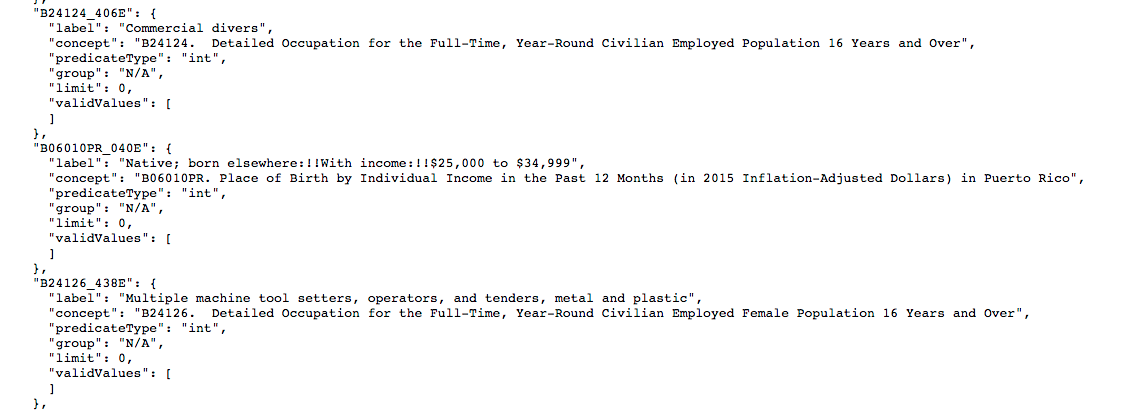

The data that was collected from the census is not consistent every year. As a result I had to limit my search to 2011-2015 as those were the years with consistent variables that were recorded. As shown in the image above the json file is a dictionary of variables with code as their keys. Each code corresponds with a dictionary with keys named label, concept, preicatetype, group, limit, and prediacteonly. I was interested in the collecting the code, label, and concepts of the topics listed above in order to collect information for those topics

In [31]:
#get the targeted variables from json
def var_data(var_list, variable_code):
    variable_dic = {}
    variable_list = []
    for code in var_list['variables']:
        if code.startswith(variable_code) and code.endswith('E'):
            variable_list.append(code)
            variable_dic[code] = var_list['variables'][code]['concept'] + '_' +var_list['variables'][code]['label']
    return variable_list, variable_dic

In [69]:
#collect data fro specified year
def collecting_data_for_specific_year(YYYY, state_code,state_abb, var_list,var_dic): 
    #load a json file containing all the codes for variables in variable list
    #find the code on this website http://api.census.gov/data/2014/acs5/variables.json
    census_api_key = 'b9a9255e89915659ba885b13a0e1d5138ccb6ddc'
    base_url = ' http://api.census.gov/data/'
    list_of_df = []
    while len(var_list) > 0:
        final_url = base_url + str(YYYY) + '/acs5?get=' + ','.join(sorted(var_list[:50])) + '&for=county+subdivision:*&in=state:' + str(state_code) + '&key=' + str(census_api_key)
        json_data = urllib2.urlopen(final_url)
        df = json.load(json_data)
        df= pd.DataFrame(df)
        var_list = var_list[50:]
        list_of_df.append(df.iloc[:,:-3])
        location = df.iloc[:, -3:]
    list_of_df.append(location)
    dataframe = pd.concat(list_of_df, axis = 1)
    dataframe.columns = dataframe.iloc[0, :]
    dataframe = dataframe.iloc[2:, :]
    for code in dataframe.columns[:-3]:
        dataframe.rename(columns={code: var_dic[code]}, inplace=True)
    #find code that matches county name
    county_dic ={}
    county_sub_div_dic={}
    county = 'http://www2.census.gov/geo/docs/reference/codes/files/st' + str(state_code) + '_' + state_abb + '_cousub.txt'
    county = urllib2.urlopen(county).readlines()
    county = csv.reader(county, delimiter = ',') 
    for line in county:
        county_dic[line[2]] = line[3]
        county_sub_div_dic[line[4]] = line[5]
        
    #remove town or Town city from city name
    for key in county_sub_div_dic:
        county_sub_div_dic[key] = re.sub(' t*T*own\s*\w*', '', county_sub_div_dic[key])
        county_sub_div_dic[key] = re.sub(' city', '', county_sub_div_dic[key])

    dataframe['county'] = dataframe['county'].map(county_dic)
    dataframe['county subdivision'] = dataframe['county subdivision'].map(county_sub_div_dic)
    dataframe.set_index(dataframe['county subdivision'], inplace = True)
    dataframe = dataframe.drop(['county', 'county subdivision', 'state'], axis=1) 
    #dataframe = dataframe.fillna(0)
    dataframe = dataframe.astype(float)
    return dataframe

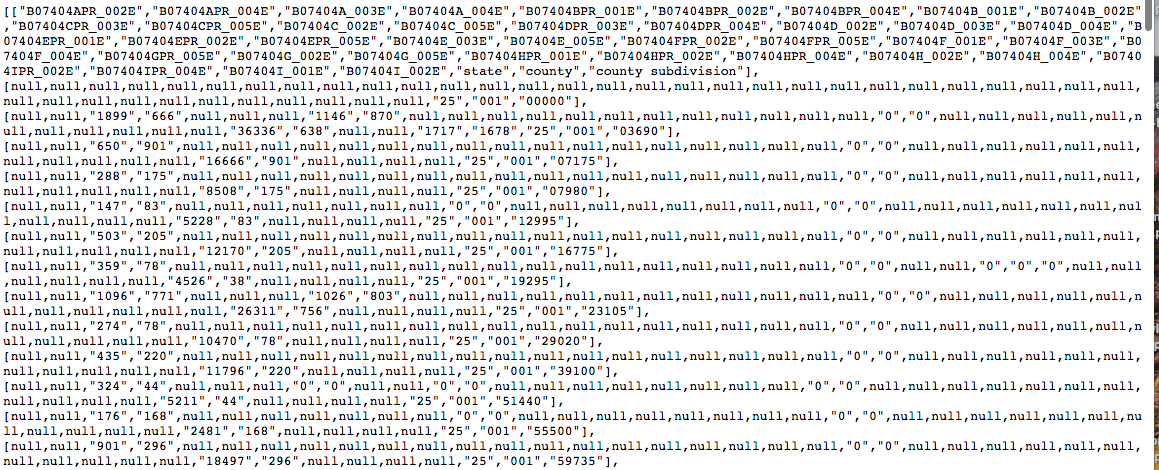

The script above is used to collect the data on the census api for a specified year. Using the base url followed by the year, type of variables desired, etc the final url outputs a list of lists. The first list corresponds with variables collected and later lists gives the numbers collected for each variable. 

In [70]:
#collect data from multiple year
def collecting_data_for_multiple_years(years, state_code, state_abb, var_list, var_dict):
    y = {}
    for year in years:
        df = collecting_data_for_specific_year(year, state_code,state_abb, var_list,var_dict)
        y[year] = df
    return y

In [71]:
def collect_target_variables(var_dic, list_of_vars, var_data):
    list_of_target_variables = []
    for v in list_of_vars:
        l, d = var_data(var_dic, v)
        list_of_target_variables.append([l,d])
    return list_of_target_variables

In [72]:
target_var = ['B08136','B07404','B07010','B07012', 'B07401','B20001', 'B01001B', 'B25034', 'B19001']

In [73]:
tar_var = collect_target_variables(var, target_var, var_data)

In [74]:
def df_tar_var(tar_var_list, start_year, end_year):
    dic = {}
    i = 0
    for v in tar_var_list:
        df = collecting_data_for_multiple_years(range(start_year, end_year + 1), 25, 'ma', v[0], v[1])
        dic[i] = df
        i = i + 1
    return dic

In [75]:
#get the data for each variable from 2011 to 2015
df = df_tar_var(tar_var, 2011, 2015)

In [51]:
pickle_out = open('census_df_na', 'wb')
pickle.dump(df, pickle_out)
pickle_out.close()
#pickle_in = open('census_df_na', 'rb')
#df = pickle.load(pickle_in)

As shown in the list of list above, there are some columns that have many null values. To reduce my variable size I decided only to keep columns that were at least 50% filled in.

In [83]:
#Remove all columns with more than 50% nulls
na_dic = {}
for key in df:
    na_dic[key]={}
    for y in df[key]:
        na_dic[key][y]={}
        for col in df[key][y].columns.values:
            percent_na = df[key][y].loc[:,col].isnull().sum().astype(float) / (len(df[key][y].index))
            if percent_na <=0.5:
                na_dic[key][y][col] = {}
                na_dic[key][y][col] = percent_na

In [84]:
def df_to_keep(df, na_dic):
    for k in df:
        for y in df[k]:
            new_df = df[k][y].loc[:,na_dic[k][y].keys()]
            new_df = new_df[new_df.index != 'County subdivisions not defined']
            df[k][y] = new_df
    return df
df = df_to_keep(df, na_dic)

Now that we have collected the data I needed to find the price in which each area sold for. Conveniently, zillow data recording the median list price per square foot for each sub county. Ideally they would have the median sale price per square foot but this will have to do.

In [85]:
#read zillow csv and group the median list price by mean of each year
def zillow_data(csv_file, state):
    z = pd.read_csv(csv_file)
    t = []
    for i in z.iloc[:, 5:].columns.tolist():
        t.append(i[:-3])
    z_ma = z.loc[z['State'] == 'MA'].set_index(['RegionName']).iloc[:, 4:]
    z_ma.columns = t
    z_ma = z_ma.transpose().groupby(t).mean()
    return z_ma



In [86]:
median_list_price = zillow_data('City_MedianListingPricePerSqft_AllHomes.csv', 'MA')

Some of the cities that were recorded on the zillow were not found in the census dataset and vice versa. Therefore I limited my dataset to the cities that were found in both datasets. The price variable was then added into the census dataset by cities. 

In [87]:
#find common cities in the zillow csv and the collected df from census 
def common_cities_between_zillow_and_df(dic_of_df, zillow, start_year, end_year):
    df_w_zillow ={}
    for key in dic_of_df:
        df_w_zillow[key] = {}
        for year in range(start_year, end_year + 1):
            df = dic_of_df[key][year]
            df['price'] = 0
            for cities in df.index.tolist():
                try:
                    df.loc[cities, 'price'] = zillow.loc[str(year), cities]
                except (KeyError, TypeError, ValueError):
                    continue
            df = df.loc[df['price'] > 0]
            df_w_zillow[key][year] = df
    return df_w_zillow

In [88]:
zillow_df = common_cities_between_zillow_and_df(df, median_list_price, 2011, 2015)

As I mentioned previously, I removed columns in which more than 50% of the values were null. However, this still leaves me with a dataset with null values. What do these null values really mean though? Does it mean that the government was unable to collect data from these particular cities for this variable or was 'None' just another way of saying 0?

([<matplotlib.axis.XTick at 0x113aa2f10>,
 <a list of 2 Text xticklabel objects>)

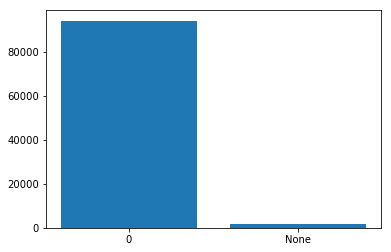

In [21]:
#merge all dataframe and graph none vs 0
df_list = []
for k in zillow_df:
    for y in zillow_df[k]:
        df_list.append(zillow_df[k][y].iloc[:,:-1])
all_df = pd.concat(df_list, axis = 1)
zeros = len(all_df.stack()[all_df.stack()== 0])
nas = len(all_df.isnull().sum()[all_df.isnull().sum() > 0])
plt.bar(np.arange(2), [zeros, nas])
plt.xticks(np.arange(2), ('0', 'None'))

As visulized by the graph above. There are clearly many zeroes in the data set. Therefore it would be unwise to assume that None means 0. A way to fill in these zeroes would include replacing the null values for that particular city with a city that has similar numbers. This idea is essentially utilizing collaborative filtering to fill in the missing data. 

In [135]:
#replace null values with collaborative filtering
def replace_na(df):
    new_df = {}
    for k in df:
        new_df[k]={}
        for y in df[k]:
            n = df[k][y].transpose()
            na_col = n.isnull().sum()[n.isnull().sum()>0].index.values
            for c in na_col:
                num_c = n[c]
                sim_c = n.corrwith(num_c)
                #print(n.index)
                melt = n.reset_index().melt(id_vars=[0])
                #get all the index that are missing in column
                missing_var = melt[(melt['county subdivision'] == c) & (melt['value'].isnull())][0].tolist()
                val_c = melt[(melt[0].isin(missing_var)) & (melt['county subdivision'] != c) & (melt['value'].notnull())]
                val_c['value'] = val_c['value'].map(int)
                val_c['similarity'] = val_c['county subdivision'].map(sim_c.get)
                val_c['sim_val'] = val_c.similarity * val_c.value
                new_val = val_c.groupby(0).apply(lambda s: s.value.sum() / s.similarity.sum())
                i = 0
                for v in new_val.index:
                    n.loc[v,c] = new_val[i]
                    i = i + 1
            new_n = n.astype(float)
            new_df[k][y]={}
            new_df[k][y] = new_n
    return(new_df)

In [136]:
new_df = replace_na(zillow_df)

/Users/JenniferLa/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/JenniferLa/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/JenniferLa/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [142]:
for k in new_df:
    for y in new_df[k]:
        new_df[k][y] = new_df[k][y].transpose()

In [3]:
#pickle_out = open('census_df_with_price_no_na', 'wb')
#pickle.dump(new_df, pickle_out)
#pickle_out.close()
pickle_in = open('census_df_with_price_no_na', 'rb')
df_no_na = pickle.load(pickle_in)

After filling in the null values I wanted to normalize the data based on percent change. For each year I calculated the percent change of each variable from last years values. The equation for percent change is simply (current year - before year) / (before year). One thing to be cautious of is that there were many 0's in the dataframe as shown from the graph above. To avoid having to divide by zero I decided to add 0.1 to each number in the dataframe. Further my goal was to find areas that would increase in price ajusted for inflation. Given that inflation varies from 2-3% per year I denoted increase of price as prices above 3% (value of 1) and all other prices were considered no increase (value of 0).

In [4]:
#calculate the percent change in each variable by last years values
def percent_change_from_last_year(dic_of_dic, start_year, end_year):
    new_dic = {}
    for key in dic_of_dic.keys():
        new_dic[key] = {}
        for year in range(start_year+1, end_year+1):
            current_year = dic_of_dic[key][year] + 1
            previous_year = dic_of_dic[key][year-1] + 1
            sub_df = current_year.subtract(previous_year, axis = 0)
            percent_change = sub_df.divide(previous_year, axis = 0) * 100
            new_dic[key][year] = percent_change
    return new_dic

In [5]:
percent_change = percent_change_from_last_year(df_no_na, 2011, 2015)

In [6]:
def merge_df_based_on_year(dic_of_df, start_year, end_year):
    list_of_df = []
    for y in range(start_year, end_year+1):
        year_df = []
        for k in dic_of_df:
            year_df.append(dic_of_df[k][y].iloc[:,:-1])
            price = dic_of_df[k][y].loc[:,'price']
        year_df.append(price)
        result = pd.concat(year_df, axis=1)
        result = result.fillna(0)
        result = result.reset_index()
        list_of_df.append(result)
    return list_of_df
        
l_of_d = merge_df_based_on_year(percent_change, 2012, 2015)
            

In [7]:
#find areas of increased price
for df in l_of_d:
    price = df['price']
    p_high = price >= 3
    df['price'] = p_high.astype(int)

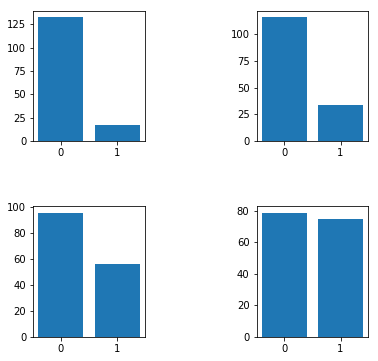

In [8]:
#plot price distribution
fig, axs = plt.subplots(2, len(l_of_d)/2, figsize = (6,6))
fig.subplots_adjust(hspace = .5, wspace= 1)
axs = axs.ravel()
for i in range(len(l_of_d)):
    axs[i].bar([0,1] ,l_of_d[i]['price'].value_counts())

As shown from the graph above there seems to be an unbalanced dataset for the 3 out of the 4 years. Given that it is difficult to classify unbalanced datasets we can collected more data. Alternatively, we can combine the datasets since everything is already normalized.

In [9]:
#merge all df
merge_all = pd.concat(l_of_d, axis = 0)

([<matplotlib.axis.XTick at 0x11c390990>,
 <a list of 2 Text xticklabel objects>)

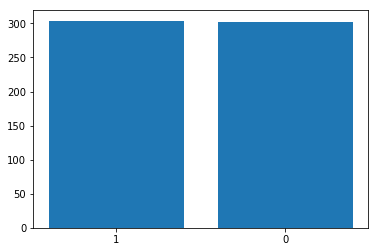

In [10]:
fig, ax = plt.subplots()
counts = pd.DataFrame(merge_all['price'].value_counts())
x = np.arange(2)
plt.bar(x,[counts.iloc[0,0], counts.iloc[1,0]])
plt.xticks(x, (counts.index[0], counts.index[1]))

As shown from the graph above the merged dataframe has an equal distribution of areas with increased housing price as denoted by the 1 and areas with no increase in housing price denoted by the 0.

In [13]:
x = merge_all.iloc[:, 1:-1]
x_np = np.sort(x.var())
var = [go.Bar(
            x= np.arange(len(x_np)),
            y=x_np
    )]
plotly.offline.iplot(var)


# Modeling  
I decided to use variance threshold as a quick and dirty feature selection technique. Columns that do not meet a specific threshold variance will not be included in the modeling. The rational is that variables with low variance are not likely contribute to predicting the target variable. A random forest classifier with varying minimum sample leaf (to decrease overfitting) options was used for the prediction algorithm. 

In [14]:
var = VarianceThreshold()
rf = RandomForestClassifier(n_estimators = 100)
pipe = Pipeline(steps=[('var', var), ('rf', rf)])

x = merge_all.iloc[:, 1:-1]
y = merge_all.loc[:,'price']

# Prediction
threshold = [0, x.var().mean(), x.var().mean() *2]
min_samples_leaf = [5,10,20,40]

estimator = GridSearchCV(pipe,
                         dict(var__threshold = threshold,
                              rf__min_samples_leaf = min_samples_leaf
                             ), cv=10)
estimator.fit(x, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('var', VarianceThreshold(threshold=0.0)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'var__threshold': [0, 111394.81652109661, 222789.63304219322], 'rf__min_samples_leaf': [5, 10, 20, 40]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [16]:
x_label = ['Five', 'Ten', 'Twenty', 'Forty']
var = [0, x.var().mean(), x.var().mean() *2]
def plot_estimator(e, x_label, var):
    mean_score = e.cv_results_['mean_test_score']
    index = []
    plot_trace = []
    for i in range(len(var)):
        ind = np.arange(i, len(mean_score), len(var))
        index.append(ind)
    plot_trace = []
    for i in range(len(var)):
        t = go.Bar(
            x = x_label,
            y = mean_score[index[i]],
            name = str(var[i])
        )
        plot_trace.append(t)
    layout = go.Layout(barmode = 'group')
    fig = go.Figure(data = plot_trace, layout = layout)
    return(plotly.offline.iplot(fig))
    
plot_estimator(estimator, x_label, var)


## Other Metric Measures
At the end of the day I am looking to be able to decide whether or not I should purchase a condo depending on the given variables. Things I want is to correctly classify those house that are actually going to go up (true positives). The most deterimental scenerio would be to purchase a place and have the house go not go up in value (false positive). Ideally I have a high true positive rate and a low false positive rate. To look at this metric I will utlize a confusion matrix

In [17]:
#confusion matrix
x = merge_all.iloc[:, 1:-1]
min_max_scaler = preprocessing.MinMaxScaler()
x = pd.DataFrame(min_max_scaler.fit_transform(x))
y = merge_all.loc[:,'price']
sel = VarianceThreshold(x.var().mean()*2)
sel = sel.fit_transform(x)
rfc = RandomForestClassifier(min_samples_leaf= 40)
tp_list = []
fn_list = []
fp_list = []
tn_list = []
for i in range(10):
    y_pred = cross_val_predict(rfc,x,y,cv=10)
    cm = confusion_matrix(y_pred, y, labels=[1,0])
    tp_list.append(cm[0,0])
    fn_list.append(cm[0,1])
    fp_list.append(cm[1,0])
    tn_list.append(cm[1,1])
stat_list = [tp_list, fn_list, fp_list, tn_list]
mean_list = []
std_list = []
for l in stat_list:
    mean_list.append(np.mean(l))
    std_list.append(np.std(l))

data = [
    go.Bar(
        x = ['TP', 'FN', 'FP', 'TN'],
        y = mean_list,
        error_y =dict(
            type ='data',
            array = std_list,
            visible=True
        )
    )
]

plotly.offline.iplot(data)

In [71]:
precision = float(mean_list[0]) / float(mean_list[0] + mean_list[2])
print'The precision is :', precision
recall = float(mean_list[0]) / float(mean_list[0] + mean_list[1])
print'The recall is :', recall


The precision is : 0.663725490196
The recall is : 0.631529850746


## Final Thoughts 
As shown from the confusion matrix above I have a precision of 66% meaning out of all the positive values predicted, 66% of them will actually be houses in areas that will go up in price. The recall of 63% tells me that out of all the areas with likelihood of housing price going up the algorithm was able to correctly predict 63% of those counties.

Given these metrics, the algorithm above may not be good enough to make large investments like buying a home. Future directions would include testing other algorithms that may be able to reduce FP and increase TP classifications. However, it is important to consider that we do not have enough data to make such predictions. The variables selected was just a small fraction of what is available on the census website. Perhaps these variables may contribute to housing price increase but only weakly, as shown by the precision of 66%. Another possibility is that the changes to each variable may not result in an immediate price difference which is what I tried to access. Maybe the increase in housing price lags a year or two post variable change. I was unable to test this hypothesis given the lack of data for years before 2011/after 2015. Additionally, the census data may have selection bias. There may certain populations are more prone to filling out the census surveys resulting in an inaccurate representation of the the population change in that area. Perhaps finding other sources of data in addition to the census data may be required. 